# 언어 모델을 사용한 문장 생성

In [1]:
import numpy as np
from common.functions import softmax

In [6]:
from common.time_layers import *
from common.base_model import BaseModel
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

In [7]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        # start_id : 최초로 주는 단어의 ID, sample_size : 샘플링하는 단어의 수, skip_ids : ID의 리스트 (샘플링 되지 않을 단어)
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            # 각 단어의 점수를 출력
            score = self.predict(x)
            # 점수들을 softmax를 통해 정규화, 확률분포 p를 얻음
            p = softmax(score.flatten())
            
            # p로부터 다음 단어를 샘플링 : np.random.choice() 사용
            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids

In [10]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

# 시작 문자와 건너뜀 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>','$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you rattled volokh parsow portions skiers she prisoner staffs self-employed cos. gregory posts cie. would-be festival studios vegas scattered conglomerate gainers alleges preliminary troops identified recognizes deliberations snapped perform big spectrum financial scheduled microwave tuesday pro kill tourism polly spotted efforts august exports create dissident sens. abused sank outfit long-awaited investigation adults if c$ expensive earnings act mere triple-a illustration possibilities digs whatever problem laying couples nikkei financiers alliance ahmanson dismiss completion licenses compelling messages little diamonds recruited defective sight availability flooded patterns 30-share different aware squeeze function technology financing challenge sells retreat mackenzie grace lucrative burton conservatorship lend fact


In [11]:
model.load_params('Rnnlm.pkl')

# 시작 문자와 건너뜀 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>','$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you reduces it noticed that there is the slow economy and not going to let them.
 many people still examined toward the two countries as milestones street disk care is very safe.
 mr. honecker surged to the massacre since he plummeted by penn oct. it was calling up with a series of payments to between five million academic offices on the east.
 he suggested that he had had plans on the east german taxpayer ralph gorbachev may cut of a single version.
 posed by a change of employees mr. jones has made matters to caution and


# seq2seq
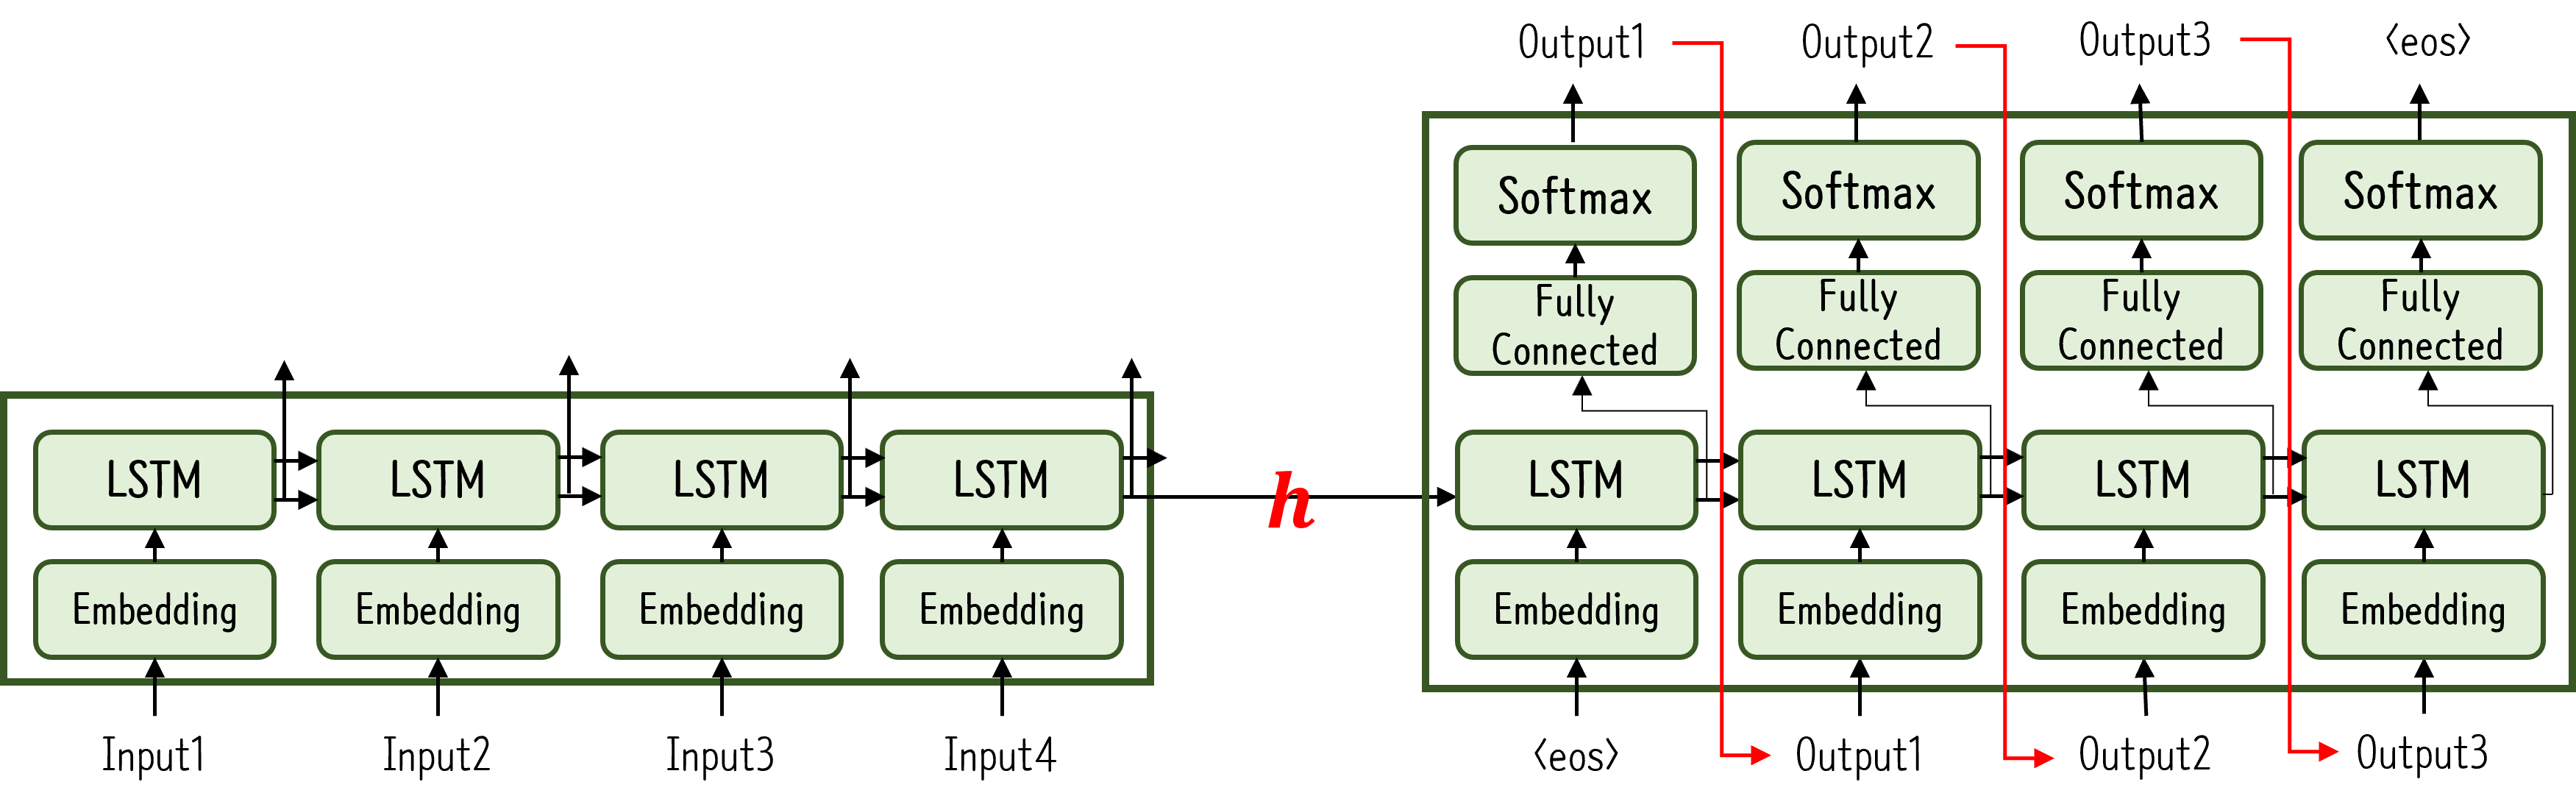
- encoder-decoder 모델
    - h는 고정 벡터
- 장난감 문제

In [15]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


# 구현

### 1. Encoder 클래스

In [17]:
from common.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # V : 어휘의 수(문자의 종류), D : 문자 벡터 차원의 수, H : lstm 은닉 상태 벡터의 차원 수
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        # time embedding, time lstm 계층 호출
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        # time lstm 계층의 마지막 시각의 은닉 상태만을 추출
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


### 2. Decoder 클래스

In [18]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### 3. seq2seq 클래스

In [19]:
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 4. 평가

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 2[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 6[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838

| 에폭 8 |  반복 81 / 351 | 시간 1[s] | 손실 1.03
| 에폭 8 |  반복 101 / 351 | 시간 2[s] | 손실 1.05
| 에폭 8 |  반복 121 / 351 | 시간 2[s] | 손실 1.04
| 에폭 8 |  반복 141 / 351 | 시간 2[s] | 손실 1.05
| 에폭 8 |  반복 161 / 351 | 시간 3[s] | 손실 1.05
| 에폭 8 |  반복 181 / 351 | 시간 3[s] | 손실 1.02
| 에폭 8 |  반복 201 / 351 | 시간 4[s] | 손실 1.03
| 에폭 8 |  반복 221 / 351 | 시간 4[s] | 손실 1.02
| 에폭 8 |  반복 241 / 351 | 시간 4[s] | 손실 1.02
| 에폭 8 |  반복 261 / 351 | 시간 5[s] | 손실 1.02
| 에폭 8 |  반복 281 / 351 | 시간 5[s] | 손실 1.05
| 에폭 8 |  반복 301 / 351 | 시간 6[s] | 손실 1.06
| 에폭 8 |  반복 321 / 351 | 시간 6[s] | 손실 1.05
| 에폭 8 |  반복 341 / 351 | 시간 6[s] | 손실 1.04
Q 77+85  
T 162 
☒ 166 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 157 
---
Q 367+55 
T 422 
☒ 411 
---
Q 600+257
T 857 
☒ 837 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1449
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 227 
---
검증 정확도 4.140%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.01
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.02
| 에폭 9 |  반복 41 / 351 

| 에폭 15 |  반복 101 / 351 | 시간 1[s] | 손실 0.87
| 에폭 15 |  반복 121 / 351 | 시간 2[s] | 손실 0.86
| 에폭 15 |  반복 141 / 351 | 시간 2[s] | 손실 0.87
| 에폭 15 |  반복 161 / 351 | 시간 3[s] | 손실 0.90
| 에폭 15 |  반복 181 / 351 | 시간 3[s] | 손실 0.88
| 에폭 15 |  반복 201 / 351 | 시간 3[s] | 손실 0.87
| 에폭 15 |  반복 221 / 351 | 시간 4[s] | 손실 0.88
| 에폭 15 |  반복 241 / 351 | 시간 4[s] | 손실 0.87
| 에폭 15 |  반복 261 / 351 | 시간 5[s] | 손실 0.90
| 에폭 15 |  반복 281 / 351 | 시간 5[s] | 손실 0.86
| 에폭 15 |  반복 301 / 351 | 시간 5[s] | 손실 0.89
| 에폭 15 |  반복 321 / 351 | 시간 6[s] | 손실 0.87
| 에폭 15 |  반복 341 / 351 | 시간 6[s] | 손실 0.86
Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1108
---
Q 582+84 
T 666 
☒ 662 
---
Q 8+155  
T 163 
☒ 158 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1421
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93 
T 236 
☑ 236 
---
검증 정확도 5.780%
| 에폭 16 |  반복 1 / 351 | 시간 0[s] | 손실 0.89
| 에폭 16 |  반복 21 / 351 | 시간 0[s] | 손실 0.87
| 에폭 16 |  반복 41 / 351 | 시간 0[s] | 손실 0.86
| 에폭 1

| 에폭 22 |  반복 121 / 351 | 시간 2[s] | 손실 0.79
| 에폭 22 |  반복 141 / 351 | 시간 2[s] | 손실 0.80
| 에폭 22 |  반복 161 / 351 | 시간 3[s] | 손실 0.83
| 에폭 22 |  반복 181 / 351 | 시간 3[s] | 손실 0.79
| 에폭 22 |  반복 201 / 351 | 시간 3[s] | 손실 0.81
| 에폭 22 |  반복 221 / 351 | 시간 4[s] | 손실 0.84
| 에폭 22 |  반복 241 / 351 | 시간 4[s] | 손실 0.88
| 에폭 22 |  반복 261 / 351 | 시간 5[s] | 손실 0.78
| 에폭 22 |  반복 281 / 351 | 시간 5[s] | 손실 0.79
| 에폭 22 |  반복 301 / 351 | 시간 5[s] | 손실 0.78
| 에폭 22 |  반복 321 / 351 | 시간 6[s] | 손실 0.80
| 에폭 22 |  반복 341 / 351 | 시간 6[s] | 손실 0.80
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 655 
---
Q 8+155  
T 163 
☒ 172 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 850 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1420
---
Q 26+838 
T 864 
☒ 862 
---
Q 143+93 
T 236 
☒ 242 
---
검증 정확도 8.620%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.80
| 에폭 23 |  반복 21 / 351 | 시간 0[s] | 손실 0.80
| 에폭 23 |  반복 41 / 351 | 시간 0[s] | 손실 0.77
| 에폭 23 |  반복 61 / 351 | 시간 1[s] | 손실 0.83
| 에폭 23

/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/cor

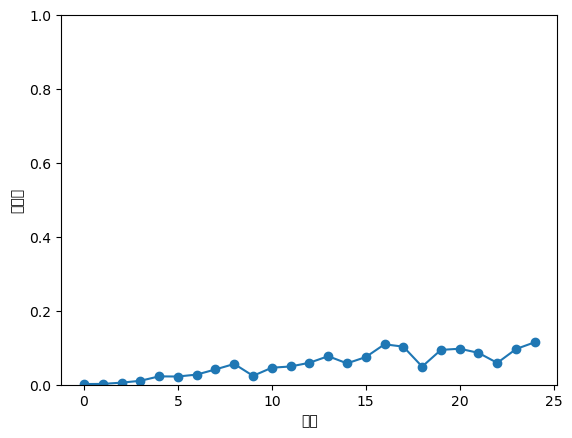

In [21]:
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

# 개선

### 1. 입력 데이터의 반전

In [ ]:
# (x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
# x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

### 2. 엿보기(Peekly)

In [22]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 6[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 7[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 7[s] | 손실 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1013
---
Q  48+285
T 666 
☒ 102 
---
Q   551+8
T 163 
☒ 100 
---
Q  55+763
T 422 
☒ 1023
---
Q 752+006
T 857 
☒ 1023
---
Q 292+167
T 1053
☒ 1023
---
Q 795+038
T 1427
☒ 1111
---
Q  838+6

| 에폭 8 |  반복 81 / 351 | 시간 1[s] | 손실 0.47
| 에폭 8 |  반복 101 / 351 | 시간 2[s] | 손실 0.46
| 에폭 8 |  반복 121 / 351 | 시간 2[s] | 손실 0.46
| 에폭 8 |  반복 141 / 351 | 시간 3[s] | 손실 0.44
| 에폭 8 |  반복 161 / 351 | 시간 3[s] | 손실 0.41
| 에폭 8 |  반복 181 / 351 | 시간 3[s] | 손실 0.42
| 에폭 8 |  반복 201 / 351 | 시간 4[s] | 손실 0.41
| 에폭 8 |  반복 221 / 351 | 시간 4[s] | 손실 0.40
| 에폭 8 |  반복 241 / 351 | 시간 5[s] | 손실 0.39
| 에폭 8 |  반복 261 / 351 | 시간 5[s] | 손실 0.37
| 에폭 8 |  반복 281 / 351 | 시간 6[s] | 손실 0.36
| 에폭 8 |  반복 301 / 351 | 시간 6[s] | 손실 0.36
| 에폭 8 |  반복 321 / 351 | 시간 7[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 7[s] | 손실 0.34
Q   58+77
T 162 
☒ 161 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☒ 657 
---
Q   551+8
T 163 
☒ 155 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☒ 1438
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351

| 에폭 15 |  반복 101 / 351 | 시간 2[s] | 손실 0.05
| 에폭 15 |  반복 121 / 351 | 시간 2[s] | 손실 0.04
| 에폭 15 |  반복 141 / 351 | 시간 3[s] | 손실 0.04
| 에폭 15 |  반복 161 / 351 | 시간 3[s] | 손실 0.04
| 에폭 15 |  반복 181 / 351 | 시간 4[s] | 손실 0.04
| 에폭 15 |  반복 201 / 351 | 시간 4[s] | 손실 0.04
| 에폭 15 |  반복 221 / 351 | 시간 4[s] | 손실 0.04
| 에폭 15 |  반복 241 / 351 | 시간 5[s] | 손실 0.03
| 에폭 15 |  반복 261 / 351 | 시간 5[s] | 손실 0.04
| 에폭 15 |  반복 281 / 351 | 시간 6[s] | 손실 0.04
| 에폭 15 |  반복 301 / 351 | 시간 6[s] | 손실 0.04
| 에폭 15 |  반복 321 / 351 | 시간 7[s] | 손실 0.04
| 에폭 15 |  반복 341 / 351 | 시간 7[s] | 손실 0.04
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☑ 1427
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 96.400%
| 에폭 16 |  반복 1 / 351 | 시간 0[s] | 손실 0.02
| 에폭 16 |  반복 21 / 351 | 시간 0[s] | 손실 0.04
| 에폭 16 |  반복 41 / 351 | 시간 0[s] | 손실 0.04
| 에폭 

| 에폭 22 |  반복 101 / 351 | 시간 2[s] | 손실 0.03
| 에폭 22 |  반복 121 / 351 | 시간 2[s] | 손실 0.03
| 에폭 22 |  반복 141 / 351 | 시간 3[s] | 손실 0.02
| 에폭 22 |  반복 161 / 351 | 시간 3[s] | 손실 0.02
| 에폭 22 |  반복 181 / 351 | 시간 3[s] | 손실 0.03
| 에폭 22 |  반복 201 / 351 | 시간 4[s] | 손실 0.03
| 에폭 22 |  반복 221 / 351 | 시간 4[s] | 손실 0.02
| 에폭 22 |  반복 241 / 351 | 시간 5[s] | 손실 0.03
| 에폭 22 |  반복 261 / 351 | 시간 5[s] | 손실 0.02
| 에폭 22 |  반복 281 / 351 | 시간 6[s] | 손실 0.02
| 에폭 22 |  반복 301 / 351 | 시간 6[s] | 손실 0.02
| 에폭 22 |  반복 321 / 351 | 시간 7[s] | 손실 0.02
| 에폭 22 |  반복 341 / 351 | 시간 7[s] | 손실 0.02
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☑ 1427
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 98.220%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 23 |  반복 21 / 351 | 시간 0[s] | 손실 0.01
| 에폭 23 |  반복 41 / 351 | 시간 0[s] | 손실 0.01
| 에폭 

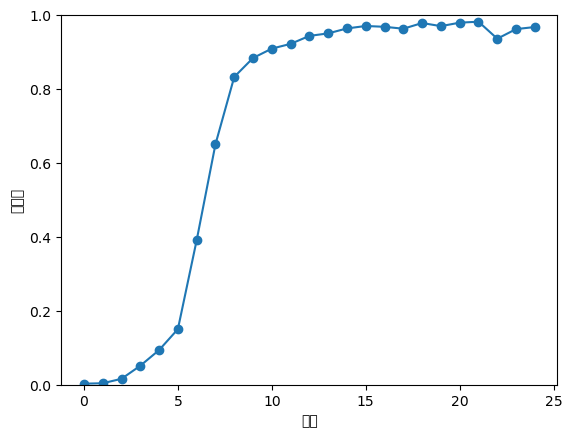

In [23]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()